# Загрузка и обработка данных

**Введение:**

В данном ноутбуке реализована полносвязная нейронная сеть (FCNN) в качестве альтернативы модели ансамблированного бустинга для модуля классического ML. Данный подход применён для следующих элементов:

1. FCNN в качестве замены ансамблированому бустингу с кросс-валидацией;
2. FCNN в качестве замены случайному лесу для объединения моделей нескольких фолдов.

Для показательности были использованы две вариации библиотек для построения FCNN: Tensorflow (Keras) и Pytorch.


------------------------------------------------
*Примечание:*

Все действия были произведены с большим исправленным (на предыдущих этапах) датасетом `cardio_train_correct`. Для ограниченного датасета `heart` не имеет смысла построения нейронной сети любой сложности в виду того, что любая достаточно сложная модель способна показать достаточный уровень точности в виду малого набора данных и предположительно их искусственного происхождения (что не мешает использовать модель с данным набором данных на проде, так как количество признаков по данной тематике в открытом доступе достаточно мало).

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint, randrange

from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, roc_auc_score, cohen_kappa_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.python.keras.models import Model, model_from_json
from tensorflow.keras.callbacks import EarlyStopping

import torch
import torch.nn as nn
import torch.optim as optim

import xgboost as xgb
import optuna
import joblib
import time, os

import warnings
warnings.filterwarnings('ignore')


# Загрузка датасета
df = pd.read_parquet('../data/cardio_train_correct.parquet').drop('id', axis=1)

X = df.drop('cardio', axis=1)
y = df['cardio']

# Загрузка полученных скоров по фолдам
df_score = pd.read_parquet('../data/xgb_optuna_cv.parquet')
X_score = df_score.drop('cardio', axis=1)
y_score = df_score['cardio']

## Получение скоров по фолдам из модели ручной кросс-валидации

Для работы со скорами модели XGBoost скопируем подход с предыдущего этапа (директория `tuning`) и получим таблицу для ансамблирования нейронной сетью:

In [2]:
def crossval_boosting_optuna(
        X,
        y,
        train_features,
        k_fold_fn,
        param_space,
        out_metrics,
        model_folder='models/',
        save_model_name='XGB_tuned',
        n_folds=4,
        fold_seed=42
):
    # Кросс-валидация (разбиение на фолды)
    k_fold = k_fold_fn(n_split=n_folds, random_state=fold_seed, shuffle=True)

    i = 0
    fold_scores = [[] for _ in range(len(out_metrics))]
    model_list = []

    # numpy array для записи скоров
    y_predicted_train = np.full(shape=(X.shape[0], n_folds), fill_value=-1, dtype=float)

    # Директория для хранения моделей
    os.makedirs(os.path.join(model_folder, save_model_name), exist_ok=True)

    # Обучение на фолдах
    for fold_idx, (train_index, test_index) in enumerate(k_fold.split(X, y)):
        
        i += 1
        time_start_fold = time.time()

        X_train, X_test = (X[train_features].iloc[train_index], X[train_features].iloc[test_index])
        y_train, y_test = (y.iloc[train_index], y.iloc[test_index])

        # Оптимизация гиперпараметров текущего фолда
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'objective': 'binary:logistic',
                'eval_metric': 'logloss',
                'n_jobs': -1,
            }

            model = xgb.XGBClassifier(**params)
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            y_pred = model.predict(X_test)
            score = out_metrics[0](y_test, y_pred)  # кортеж записи метрик на итерации перебора
            return score if isinstance(score, (int, float)) else score[0]   # Возвращаем значение метрики на итерации 

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=20)
        best_params = study.best_params

        # Обучение модели с лучшими параметрами
        model = xgb.XGBClassifier(**best_params)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        model_list.append(model)

        # Сохранение модели
        joblib.dump(model, os.path.join(model_folder, save_model_name, f'fold_{i}.pkl'))

        # Прогнозы OOF
        y_prob_fold = model.predict_proba(X[train_features])[:, 1]  # Делаем прогноз по всей выборки всеми моделями и формируем матрицу
        y_predicted_train[:, fold_idx] = y_prob_fold

        y_pred_fold = model.predict(X_test)

        # Метрики
        for j, metric in enumerate(out_metrics):
            score = round(metric(y_test, y_pred_fold), 5)
            fold_scores[j].append(score)
            print(f'{i} it: {score} Metric-{j} time: {round(time.time() - time_start_fold)}')

    return {
        'train_oof': y_predicted_train,
        'model_list': model_list,
        **{f'fold_score_list_{j+1}': fold_scores[j] for j in range(len(out_metrics))}
    }

In [3]:
train_features = X.columns.tolist()

# Функция разбиения на фолды
def k_fold_fn(n_split=4, random_state=42, shuffle=True):
    return StratifiedKFold(n_splits=n_split, random_state=random_state, shuffle=shuffle)

# Метрики для оценки модели
out_metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score]

# Запуск кросс-валидации c тюнингом
results = crossval_boosting_optuna(
    X, y, train_features, k_fold_fn, {}, out_metrics
)

[I 2025-05-11 19:28:19,906] A new study created in memory with name: no-name-db568230-25ea-4246-96f0-10a643639f77


[I 2025-05-11 19:28:21,898] Trial 0 finished with value: 0.6747428571428571 and parameters: {'n_estimators': 516, 'learning_rate': 0.4004020091416667, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.8111541665188812, 'colsample_bytree': 0.9042842788224639}. Best is trial 0 with value: 0.6747428571428571.
[I 2025-05-11 19:28:22,250] Trial 1 finished with value: 0.7296 and parameters: {'n_estimators': 248, 'learning_rate': 0.44887680212526215, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.5355595552737995, 'colsample_bytree': 0.7501813504794841}. Best is trial 1 with value: 0.7296.
[I 2025-05-11 19:28:23,335] Trial 2 finished with value: 0.6968571428571428 and parameters: {'n_estimators': 359, 'learning_rate': 0.17687605319183886, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.5033227096706596, 'colsample_bytree': 0.5557313410109899}. Best is trial 1 with value: 0.7296.
[I 2025-05-11 19:28:24,542] Trial 3 finished with value: 0.7338857142857143 and parameters: {'n_

[0]	validation_0-logloss:0.67696
[1]	validation_0-logloss:0.66368
[2]	validation_0-logloss:0.62737
[3]	validation_0-logloss:0.62084
[4]	validation_0-logloss:0.61815
[5]	validation_0-logloss:0.61565
[6]	validation_0-logloss:0.58326
[7]	validation_0-logloss:0.57330
[8]	validation_0-logloss:0.56899
[9]	validation_0-logloss:0.55761
[10]	validation_0-logloss:0.55495
[11]	validation_0-logloss:0.55397
[12]	validation_0-logloss:0.54863
[13]	validation_0-logloss:0.54782
[14]	validation_0-logloss:0.54756
[15]	validation_0-logloss:0.54500
[16]	validation_0-logloss:0.54370
[17]	validation_0-logloss:0.54297
[18]	validation_0-logloss:0.54142
[19]	validation_0-logloss:0.54059
[20]	validation_0-logloss:0.54009
[21]	validation_0-logloss:0.53991
[22]	validation_0-logloss:0.53929
[23]	validation_0-logloss:0.53896
[24]	validation_0-logloss:0.53859
[25]	validation_0-logloss:0.53814
[26]	validation_0-logloss:0.53774
[27]	validation_0-logloss:0.53767
[28]	validation_0-logloss:0.53753
[29]	validation_0-loglos

[I 2025-05-11 19:28:34,184] A new study created in memory with name: no-name-7d90cace-5a25-4deb-96ca-004a680773cd


1 it: 0.68607 Metric-2 time: 14
1 it: 0.72421 Metric-3 time: 14
1 it: 0.73888 Metric-4 time: 14
1 it: 0.47779 Metric-5 time: 14


[I 2025-05-11 19:28:35,798] Trial 0 finished with value: 0.7237142857142858 and parameters: {'n_estimators': 994, 'learning_rate': 0.12488057525527968, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.627436667488064, 'colsample_bytree': 0.7900579980134113}. Best is trial 0 with value: 0.7237142857142858.
[I 2025-05-11 19:28:36,468] Trial 1 finished with value: 0.7357142857142858 and parameters: {'n_estimators': 199, 'learning_rate': 0.017227239037177294, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.6851027612288927, 'colsample_bytree': 0.6881012143347858}. Best is trial 1 with value: 0.7357142857142858.
[I 2025-05-11 19:28:38,585] Trial 2 finished with value: 0.6911428571428572 and parameters: {'n_estimators': 847, 'learning_rate': 0.18608323306150676, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.7551990454407002, 'colsample_bytree': 0.8481992790900968}. Best is trial 1 with value: 0.7357142857142858.
[I 2025-05-11 19:28:39,761] Trial 3 finished with value: 0.

[0]	validation_0-logloss:0.62890
[1]	validation_0-logloss:0.60018
[2]	validation_0-logloss:0.57543
[3]	validation_0-logloss:0.56099
[4]	validation_0-logloss:0.55268
[5]	validation_0-logloss:0.54918
[6]	validation_0-logloss:0.54518
[7]	validation_0-logloss:0.54257
[8]	validation_0-logloss:0.54118
[9]	validation_0-logloss:0.53981
[10]	validation_0-logloss:0.53903
[11]	validation_0-logloss:0.53839
[12]	validation_0-logloss:0.53752
[13]	validation_0-logloss:0.53712
[14]	validation_0-logloss:0.53676
[15]	validation_0-logloss:0.53633
[16]	validation_0-logloss:0.53615
[17]	validation_0-logloss:0.53591
[18]	validation_0-logloss:0.53553
[19]	validation_0-logloss:0.53530
[20]	validation_0-logloss:0.53521
[21]	validation_0-logloss:0.53508
[22]	validation_0-logloss:0.53510
[23]	validation_0-logloss:0.53490
[24]	validation_0-logloss:0.53489
[25]	validation_0-logloss:0.53486
[26]	validation_0-logloss:0.53473
[27]	validation_0-logloss:0.53486
[28]	validation_0-logloss:0.53485
[29]	validation_0-loglos

[I 2025-05-11 19:28:53,355] A new study created in memory with name: no-name-ca330c63-78cf-4364-b1e3-4e99655db96e
[I 2025-05-11 19:28:54,254] Trial 0 finished with value: 0.7361714285714286 and parameters: {'n_estimators': 573, 'learning_rate': 0.09550947683457474, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.5593937306328343, 'colsample_bytree': 0.6302440816783685}. Best is trial 0 with value: 0.7361714285714286.
[I 2025-05-11 19:28:55,225] Trial 1 finished with value: 0.7148 and parameters: {'n_estimators': 409, 'learning_rate': 0.16755225282507386, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.5608248695695788, 'colsample_bytree': 0.9077323237917373}. Best is trial 0 with value: 0.7361714285714286.
[I 2025-05-11 19:28:56,016] Trial 2 finished with value: 0.7370285714285715 and parameters: {'n_estimators': 677, 'learning_rate': 0.44962775044955855, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.5628937093642724, 'colsample_bytree': 0.8104328985674458}. Best is

[0]	validation_0-logloss:0.67499
[1]	validation_0-logloss:0.66979
[2]	validation_0-logloss:0.65499
[3]	validation_0-logloss:0.64937
[4]	validation_0-logloss:0.64621
[5]	validation_0-logloss:0.64277
[6]	validation_0-logloss:0.63170
[7]	validation_0-logloss:0.62355
[8]	validation_0-logloss:0.61805
[9]	validation_0-logloss:0.60883
[10]	validation_0-logloss:0.60321
[11]	validation_0-logloss:0.59835
[12]	validation_0-logloss:0.59135
[13]	validation_0-logloss:0.58967
[14]	validation_0-logloss:0.58675
[15]	validation_0-logloss:0.58135
[16]	validation_0-logloss:0.57634
[17]	validation_0-logloss:0.57374
[18]	validation_0-logloss:0.56981
[19]	validation_0-logloss:0.56634
[20]	validation_0-logloss:0.56497
[21]	validation_0-logloss:0.56370
[22]	validation_0-logloss:0.56085
[23]	validation_0-logloss:0.55934
[24]	validation_0-logloss:0.55792
[25]	validation_0-logloss:0.55574
[26]	validation_0-logloss:0.55363
[27]	validation_0-logloss:0.55273
[28]	validation_0-logloss:0.55194
[29]	validation_0-loglos

[I 2025-05-11 19:29:09,759] A new study created in memory with name: no-name-21bac080-5a9b-4956-a4cb-5b12b1ad128c
[I 2025-05-11 19:29:10,503] Trial 0 finished with value: 0.7266285714285714 and parameters: {'n_estimators': 606, 'learning_rate': 0.4990550006795922, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.9459784776084161, 'colsample_bytree': 0.6493638618703559}. Best is trial 0 with value: 0.7266285714285714.
[I 2025-05-11 19:29:11,664] Trial 1 finished with value: 0.7025714285714286 and parameters: {'n_estimators': 432, 'learning_rate': 0.18690050385864698, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.6520986753527269, 'colsample_bytree': 0.9926006506381084}. Best is trial 0 with value: 0.7266285714285714.
[I 2025-05-11 19:29:12,195] Trial 2 finished with value: 0.7227428571428571 and parameters: {'n_estimators': 370, 'learning_rate': 0.3497185590604116, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6881324741162999, 'colsample_bytree': 0.996617441419006

[0]	validation_0-logloss:0.68830
[1]	validation_0-logloss:0.68248
[2]	validation_0-logloss:0.67145
[3]	validation_0-logloss:0.66642
[4]	validation_0-logloss:0.66375
[5]	validation_0-logloss:0.65989
[6]	validation_0-logloss:0.64677
[7]	validation_0-logloss:0.63729
[8]	validation_0-logloss:0.63113
[9]	validation_0-logloss:0.62127
[10]	validation_0-logloss:0.61440
[11]	validation_0-logloss:0.61032
[12]	validation_0-logloss:0.60288
[13]	validation_0-logloss:0.60110
[14]	validation_0-logloss:0.60035
[15]	validation_0-logloss:0.59354
[16]	validation_0-logloss:0.58778
[17]	validation_0-logloss:0.58424
[18]	validation_0-logloss:0.57881
[19]	validation_0-logloss:0.57445
[20]	validation_0-logloss:0.57333
[21]	validation_0-logloss:0.57271
[22]	validation_0-logloss:0.56911
[23]	validation_0-logloss:0.56669
[24]	validation_0-logloss:0.56481
[25]	validation_0-logloss:0.56199
[26]	validation_0-logloss:0.55940
[27]	validation_0-logloss:0.55835
[28]	validation_0-logloss:0.55796
[29]	validation_0-loglos

In [4]:
df_res = pd.DataFrame(results['train_oof'], columns=[f'fold_{i}' for i in range(1,5)])
df_res['cardio'] = df['cardio']
df_res.to_parquet('../data/xgb_optuna_cv.parquet')

## Подготовка данных

In [2]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, test_size = 0.25, shuffle = True)
print(X_train.shape, X_test.shape)
X_score_train, X_score_test, y_score_train, y_score_test = train_test_split(X_score, y_score, random_state = 42, stratify = y, test_size = 0.25, shuffle = True)
print(X_score_train.shape, X_score_test.shape)

(52500, 11) (17500, 11)
(52500, 4) (17500, 4)


С целью дальнейшего перевода значений признаков обоих выборок в тензоры, а также во избежание мультиколлинеарности в данных, имеет смысл перевести обе выборки в пространство главных компонент.

Для этого обучим два варианта PCA (для признаковой выборки и набора фолдовых скоров) на трейне и применим получившуюся матрицу поворота на тесте:

In [3]:
# Признаки
pca = PCA(n_components=X_train.shape[1]) # В виду ограниченности кол-ва признаков, имеет смысл не уменьшать их числа в соотношении объёма объясняющей дисперсии
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print("1. PCA на признаках.")
print("Количество главных компонент:", pca.n_components_)
print("Объяснённая дисперсия каждой компоненты:", pca.explained_variance_ratio_)
print("Суммарная объяснённая дисперсия:", sum(pca.explained_variance_ratio_), '\n')

# Скоры
pca_score = PCA(n_components=X_score_train.shape[1])
X_score_train_pca = pca_score.fit_transform(X_score_train)
X_score_test_pca = pca_score.transform(X_score_test)
print("2. PCA на скорах.")
print("Количество главных компонент:", pca_score.n_components_)
print("Объяснённая дисперсия каждой компоненты:", pca_score.explained_variance_ratio_)
print("Суммарная объяснённая дисперсия:", sum(pca_score.explained_variance_ratio_))

1. PCA на признаках.
Количество главных компонент: 11
Объяснённая дисперсия каждой компоненты: [5.43831803e-01 2.45171632e-01 1.10442371e-01 5.86022640e-02
 4.08564896e-02 3.08722431e-04 2.78814510e-04 2.20471446e-04
 1.27558673e-04 1.05270813e-04 5.46029599e-05]
Суммарная объяснённая дисперсия: 1.0000000000000002 

2. PCA на скорах.
Количество главных компонент: 4
Объяснённая дисперсия каждой компоненты: [0.99329234 0.00292589 0.00242654 0.00135522]
Суммарная объяснённая дисперсия: 0.9999999999999999


Теперь переведём оба варианта выборок в тензоры. Для Keras и Pytorch будут использоваться их собственные методы. Так, библиотека Keras в целом не требует отдельного перевода данных в тензоры, при этом в Pytorch это обязательно:  

In [4]:
# tensors for torch
# Признаки
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_valid_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_test.values, dtype=torch.int64)


# Скоры
X_score_train_tensor = torch.tensor(X_score_train_pca, dtype=torch.float32)
y_score_train_tensor = torch.tensor(y_score_train.values, dtype=torch.int64)
X_score_valid_tensor = torch.tensor(X_score_test_pca, dtype=torch.float32)
y_score_valid_tensor = torch.tensor(y_score_test.values, dtype=torch.int64)

# FCNN для признакого датасета

## Tensorflow.Keras

Построим модель FCNN с: 
* 11 признаками на вход ;
* 128 нейронами 1го скрытого слоя;
* 64 нейрона 2го скрытого слоя;
* 32 нейрона 3го скрытого слоя;
* 2 нейронами выходного слоя.

В качестве функций активации скрытого слоя выберем популярную на сегодняшний день `ReLu`, а у выходных нейронов – `sigmoid`, т.к. мы хотим интерпретировать выходные значения в терминах вероятности наличия/отсутствия у пользователя проблем с сердечно-сосудистов системой и нет смысла менять вектор таргета под категориальный формат (`uitils.to_categorical()`).

In [5]:
# Архитектура FCNN
model_dense = Sequential([
    Dense(128, activation='relu', input_shape=(11,)),
    Dropout(0.5),   # Используем также метод исключения с целью борьбы с переобучением FCNN
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_dense.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,905 (46.50 KB)

 Trainable params: 11,905 (46.50 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Компиляция модели
model_dense.compile(
    optimizer = 'adam', 
    loss = keras.losses.BinaryCrossentropy(),   # Используем в качестве функции потерь бинарную кросс-энтропию
    metrics = [
        keras.metrics.BinaryAccuracy(), # Accuracy для бинарной классификации
        keras.metrics.FalseNegatives()  # Используем ещё одну метрику для отслеживания ошибок
        ])

In [7]:
# Обучение
hist_dense = model_dense.fit(X_train_pca, y_train, batch_size = 32, validation_split = 0.2, epochs = 50)

Epoch 1/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - binary_accuracy: 0.6118 - false_negatives: 4197.3066 - loss: 0.9092 - val_binary_accuracy: 0.7306 - val_false_negatives: 1651.0000 - val_loss: 0.5815
Epoch 2/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - binary_accuracy: 0.7097 - false_negatives: 3736.8242 - loss: 0.5959 - val_binary_accuracy: 0.7324 - val_false_negatives: 1753.0000 - val_loss: 0.5773
Epoch 3/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - binary_accuracy: 0.7195 - false_negatives: 3562.4353 - loss: 0.5837 - val_binary_accuracy: 0.7350 - val_false_negatives: 1668.0000 - val_loss: 0.5677
Epoch 4/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - binary_accuracy: 0.7254 - false_negatives: 3415.8813 - loss: 0.5713 - val_binary_accuracy: 0.7370 - val_false_negatives: 1699.0000 - val_loss: 0.5579
Epoch 5/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - binary_accuracy: 0.7280 - false_negatives: 3316.8835 - loss: 0.5715 - val_binary_accuracy: 0.7373 - val_false_negatives:

Получили значение на тесте, даже превышающее точность, полученную с помощью бустинга (там accuracy около 74). Подгоним под данную модель тестовую выборку методом evaluate и посмотрим результаты на более правдоподобных метриках (для такого дисбаланса лучше оценивать по ROC-AUC):

In [8]:
model_dense.evaluate(X_test_pca, y_test)

# Получим предсказания и оценим метрики на тесте
res_train = model_dense.predict(X_train_pca)
res_test = model_dense.predict(X_test_pca)

print(f"Accuracy train: {accuracy_score(y_train, np.round(res_train))}", f"Accuracy test: {accuracy_score(y_test, np.round(res_test))}")
print(f"Precision train: {precision_score(y_train, np.round(res_train))}", f"Precision test: {precision_score(y_test, np.round(res_test))}")
print(f"Recall train: {recall_score(y_train, np.round(res_train))}", f"Recall test: {recall_score(y_test, np.round(res_test))}")
print(f"F1 train: {f1_score(y_train, np.round(res_train))}", f"F1 test: {f1_score(y_test, np.round(res_test))}")
print(f"ROC-AUC train: {roc_auc_score(y_train, res_train)}", f"ROC-AUC test: {roc_auc_score(y_test, np.round(res_test))}")
print(f"Cohen-Kappa train: {cohen_kappa_score(y_train, np.round(res_train))}", f"Cohen-Kappa test: {cohen_kappa_score(y_test, np.round(res_test))}")

547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - binary_accuracy: 0.7351 - false_negatives: 1445.1132 - loss: 0.5430
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
Accuracy train: 0.7403428571428572 Accuracy test: 0.7350285714285715
Precision train: 0.7723461272475796 Precision test: 0.7677267987486965
Recall train: 0.6811389799496836 Recall test: 0.6735277301315037
F1 train: 0.7238808993315778 F1 test: 0.7175488822561978
ROC-AUC train: 0.8042407943918635 ROC-AUC test: 0.7349934481611259
Cohen-Kappa train: 0.48064816154412804 Cohen-Kappa test: 0.47001983225333355


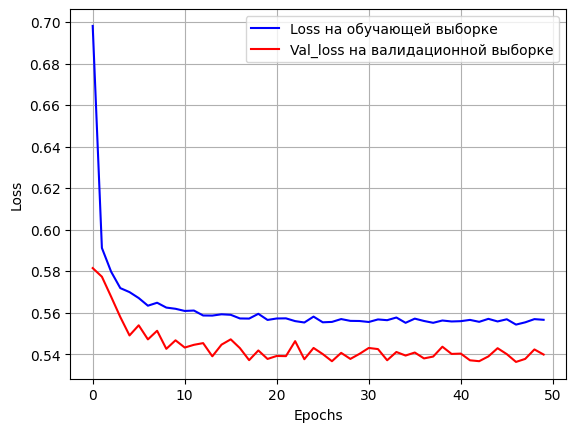

In [9]:
# Графики функций потерь на трейне и валидации для оценки переобучения
plt.plot(hist_dense.history['loss'], color = 'b', label = 'Loss на обучающей выборке')
plt.plot(hist_dense.history['val_loss'], color = 'r', label = 'Val_loss на валидационной выборке')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

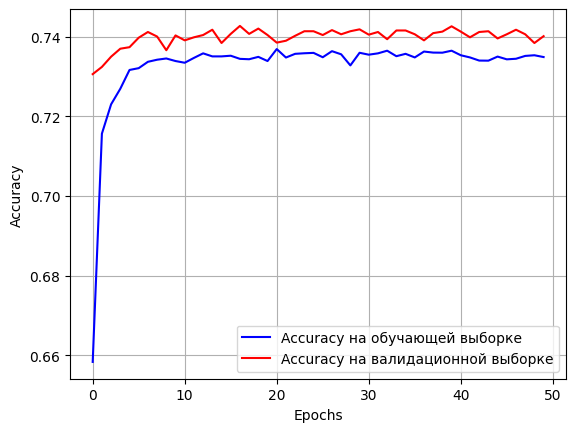

In [10]:
# Графики метрик на трейне и валидации
plt.plot(hist_dense.history['binary_accuracy'], color = 'b', label = 'Accuracy на обучающей выборке')
plt.plot(hist_dense.history['val_binary_accuracy'], color = 'r', label = 'Accuracy на валидационной выборке')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

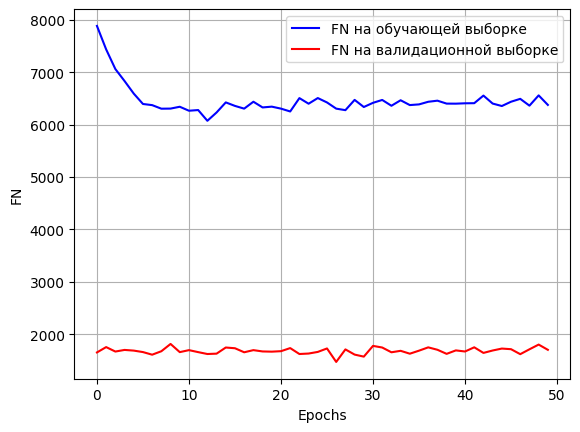

In [11]:
# Графики метрик на трейне и валидации
plt.plot(hist_dense.history['false_negatives'], color = 'b', label = 'FN на обучающей выборке')
plt.plot(hist_dense.history['val_false_negatives'], color = 'r', label = 'FN на валидационной выборке')
plt.xlabel('Epochs')
plt.ylabel('FN')
plt.legend()
plt.grid(True)
plt.show()

<Axes: >

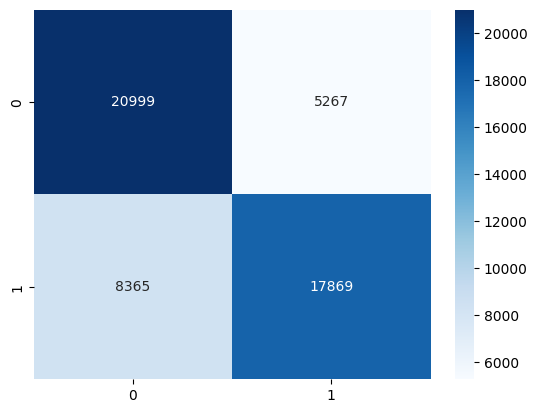

In [12]:
# Матрица ошибок на трейне
conf_matrix = confusion_matrix(y_train, np.round(res_train))
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'd')

<Axes: >

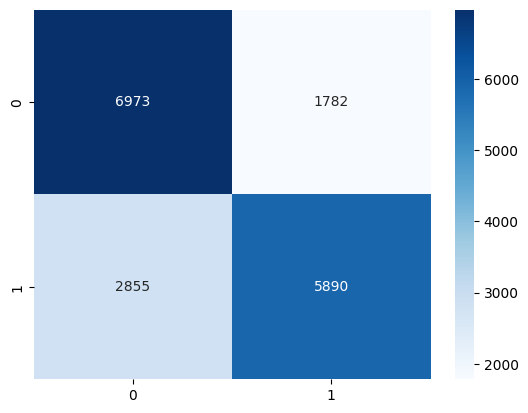

In [13]:
# Матрица ошибок на тесте
conf_matrix = confusion_matrix(y_test, np.round(res_test))
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'd')

Как видно по получившимся метрикам и графику функции потерь, данная модель является достаточно неплохой альтернативой использовавшемуся в предыдущем чекпоинте бустингу с кросс-валидацией и оптюной. Переобучения модель не имеет, а существенного различия по суммарному количеству ошибок с моделью бустинга также нет (разница буквально в нескольких десятках или сотнях строк по ошибкам).

## Pytorch

Повторим аналигичную Keras архитектуру на Pytorch, однако попробуем вместо финального слоя с сигмоидальной функцией `BCEWithLogitsLoss` (сигмоидальная + ФП бинарной кросс-энтропии):

In [14]:
import torch.nn.functional as F

In [15]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(11, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))  
        return x

In [16]:
criterion = nn.BCEWithLogitsLoss()
model = FCNN()
# На выходе — логиты (сырые значения), не применяем sigmoid вручную
outputs = model(X_train_tensor)
loss = criterion(outputs, y_train_tensor.float().unsqueeze(1))

In [17]:
# Функция оптимизации как в Keras
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    
    loss = criterion(outputs.squeeze(), y_train_tensor.float())
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.7240
Epoch 2, Loss: 0.7157
Epoch 3, Loss: 0.7082
Epoch 4, Loss: 0.7013
Epoch 5, Loss: 0.6948
Epoch 6, Loss: 0.6885
Epoch 7, Loss: 0.6823
Epoch 8, Loss: 0.6764
Epoch 9, Loss: 0.6707
Epoch 10, Loss: 0.6652
Epoch 11, Loss: 0.6600
Epoch 12, Loss: 0.6552
Epoch 13, Loss: 0.6508
Epoch 14, Loss: 0.6469
Epoch 15, Loss: 0.6434
Epoch 16, Loss: 0.6405
Epoch 17, Loss: 0.6379
Epoch 18, Loss: 0.6358
Epoch 19, Loss: 0.6340
Epoch 20, Loss: 0.6326
Epoch 21, Loss: 0.6314
Epoch 22, Loss: 0.6304
Epoch 23, Loss: 0.6296
Epoch 24, Loss: 0.6289
Epoch 25, Loss: 0.6283
Epoch 26, Loss: 0.6278
Epoch 27, Loss: 0.6274
Epoch 28, Loss: 0.6270
Epoch 29, Loss: 0.6267
Epoch 30, Loss: 0.6264
Epoch 31, Loss: 0.6262
Epoch 32, Loss: 0.6260
Epoch 33, Loss: 0.6258
Epoch 34, Loss: 0.6257
Epoch 35, Loss: 0.6255
Epoch 36, Loss: 0.6254
Epoch 37, Loss: 0.6254
Epoch 38, Loss: 0.6253
Epoch 39, Loss: 0.6252
Epoch 40, Loss: 0.6252
Epoch 41, Loss: 0.6251
Epoch 42, Loss: 0.6251
Epoch 43, Loss: 0.6250
Epoch 44, Loss: 0.62

In [18]:
# Завершение обучения модели
model.eval()

# Предсказания
with torch.no_grad():
    res_train = model(X_train_tensor).cpu().numpy().squeeze()
    res_test = model(X_valid_tensor).cpu().numpy().squeeze()

# Метрики
print(f"Accuracy train: {accuracy_score(y_train.squeeze(), np.round(res_train)):.4f}", 
      f"Accuracy test: {accuracy_score(y_test.squeeze(), np.round(res_test)):.4f}")

print(f"Precision train: {precision_score(y_train.squeeze(), np.round(res_train)):.4f}", 
      f"Precision test: {precision_score(y_test.squeeze(), np.round(res_test)):.4f}")

print(f"Recall train: {recall_score(y_train.squeeze(), np.round(res_train)):.4f}", 
      f"Recall test: {recall_score(y_test.squeeze(), np.round(res_test)):.4f}")

print(f"F1 train: {f1_score(y_train.squeeze(), np.round(res_train)):.4f}", 
      f"F1 test: {f1_score(y_test.squeeze(), np.round(res_test)):.4f}")

print(f"ROC-AUC train: {roc_auc_score(y_train.squeeze(), res_train):.4f}", 
      f"ROC-AUC test: {roc_auc_score(y_test.squeeze(), res_test):.4f}")

print(f"Cohen-Kappa train: {cohen_kappa_score(y_train.squeeze(), np.round(res_train)):.4f}", 
      f"Cohen-Kappa test: {cohen_kappa_score(y_test.squeeze(), np.round(res_test)):.4f}")

Accuracy train: 0.7441 Accuracy test: 0.7270
Precision train: 0.8285 Precision test: 0.8076
Recall train: 0.6152 Recall test: 0.5957
F1 train: 0.7061 F1 test: 0.6856
ROC-AUC train: 0.7922 ROC-AUC test: 0.7880
Cohen-Kappa train: 0.4881 Cohen-Kappa test: 0.4540


<Axes: >

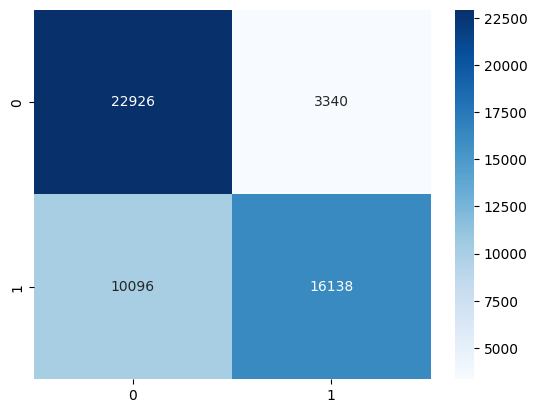

In [19]:
# Матрица ошибок на трейне
conf_matrix = confusion_matrix(y_train.squeeze(), np.round(res_train))
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'd')

<Axes: >

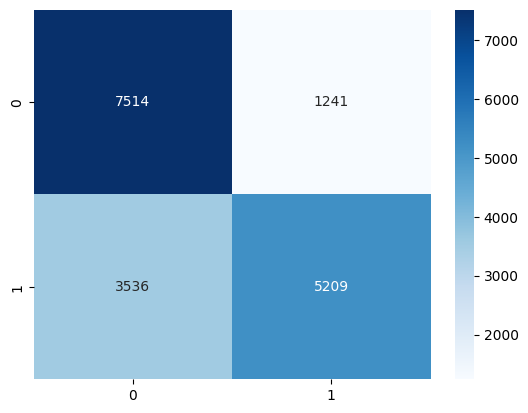

In [20]:
# Матрица ошибок на тесте
conf_matrix = confusion_matrix(y_test.squeeze(), np.round(res_test))
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'd')

In [21]:
# Выделение функции потерь
train_losses = []
val_losses = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    train_loss = criterion(outputs.squeeze(), y_train_tensor.float())
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_valid_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_valid_tensor.float())

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}: Train Loss = {train_loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

Epoch 1: Train Loss = 0.6165, Val Loss = 0.6234
Epoch 2: Train Loss = 0.6165, Val Loss = 0.6233
Epoch 3: Train Loss = 0.6165, Val Loss = 0.6235
Epoch 4: Train Loss = 0.6165, Val Loss = 0.6234
Epoch 5: Train Loss = 0.6166, Val Loss = 0.6235
Epoch 6: Train Loss = 0.6165, Val Loss = 0.6234
Epoch 7: Train Loss = 0.6165, Val Loss = 0.6235
Epoch 8: Train Loss = 0.6164, Val Loss = 0.6234
Epoch 9: Train Loss = 0.6164, Val Loss = 0.6234
Epoch 10: Train Loss = 0.6164, Val Loss = 0.6234
Epoch 11: Train Loss = 0.6164, Val Loss = 0.6234
Epoch 12: Train Loss = 0.6164, Val Loss = 0.6235
Epoch 13: Train Loss = 0.6164, Val Loss = 0.6234
Epoch 14: Train Loss = 0.6164, Val Loss = 0.6235
Epoch 15: Train Loss = 0.6164, Val Loss = 0.6234
Epoch 16: Train Loss = 0.6165, Val Loss = 0.6235
Epoch 17: Train Loss = 0.6164, Val Loss = 0.6234
Epoch 18: Train Loss = 0.6164, Val Loss = 0.6235
Epoch 19: Train Loss = 0.6163, Val Loss = 0.6235
Epoch 20: Train Loss = 0.6163, Val Loss = 0.6234
Epoch 21: Train Loss = 0.6163

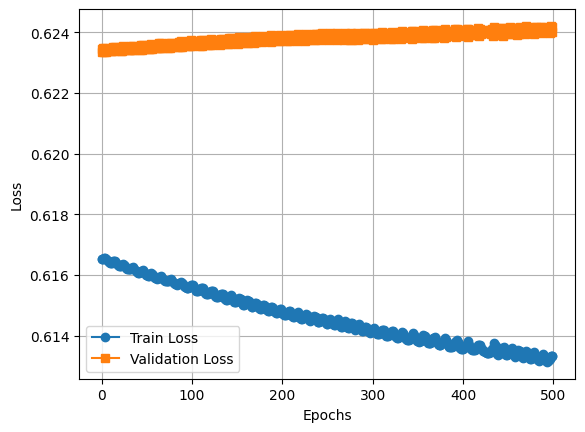

In [22]:
# Графики функций потерь на трейне и валидации для оценки переобучения
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Полносвязная нейронная сеть на Pytorch получилась гораздо стабильнее по разнице метрик и потерям по сравнению с аналогом на TensorFlow. Это произошло благодаря улучшенной функции потерь и более "ручный" и управляемым обучением по сравнению с автоматическим на Keras. Пожалуй, в качестве более жизнеспособной бустингу альтернативы следует признать FCNN на Pytorch.

# FCNN для ансамблирования скоров бустинга.

Повторим абсолютно тоже самое для второго датасета. Так как нейронная сеть на торче показала себя гораздо более стабильной к переобучению, имеет смысл рассмотреть только её:

In [26]:
class FCNN_scores(nn.Module):
    def __init__(self):
        super(FCNN_scores, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))  
        return x

In [27]:
model_scores = FCNN_scores()
outputs = model_scores(X_score_train_tensor)
loss = criterion(outputs, y_score_train_tensor.float().unsqueeze(1))

In [28]:
optimizer = torch.optim.Adam(model_scores.parameters(), lr=0.001)

# Обучение модели
for epoch in range(500):
    model_scores.train()
    optimizer.zero_grad()
    
    outputs = model_scores(X_score_train_tensor)
    
    loss = criterion(outputs.squeeze(), y_score_train_tensor.float())
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.7261
Epoch 2, Loss: 0.7250
Epoch 3, Loss: 0.7239
Epoch 4, Loss: 0.7230
Epoch 5, Loss: 0.7222
Epoch 6, Loss: 0.7214
Epoch 7, Loss: 0.7207
Epoch 8, Loss: 0.7200
Epoch 9, Loss: 0.7193
Epoch 10, Loss: 0.7186
Epoch 11, Loss: 0.7179
Epoch 12, Loss: 0.7172
Epoch 13, Loss: 0.7166
Epoch 14, Loss: 0.7158
Epoch 15, Loss: 0.7151
Epoch 16, Loss: 0.7143
Epoch 17, Loss: 0.7135
Epoch 18, Loss: 0.7126
Epoch 19, Loss: 0.7117
Epoch 20, Loss: 0.7107
Epoch 21, Loss: 0.7096
Epoch 22, Loss: 0.7085
Epoch 23, Loss: 0.7073
Epoch 24, Loss: 0.7060
Epoch 25, Loss: 0.7047
Epoch 26, Loss: 0.7033
Epoch 27, Loss: 0.7018
Epoch 28, Loss: 0.7002
Epoch 29, Loss: 0.6985
Epoch 30, Loss: 0.6967
Epoch 31, Loss: 0.6949
Epoch 32, Loss: 0.6929
Epoch 33, Loss: 0.6909
Epoch 34, Loss: 0.6887
Epoch 35, Loss: 0.6864
Epoch 36, Loss: 0.6841
Epoch 37, Loss: 0.6817
Epoch 38, Loss: 0.6791
Epoch 39, Loss: 0.6766
Epoch 40, Loss: 0.6739
Epoch 41, Loss: 0.6712
Epoch 42, Loss: 0.6684
Epoch 43, Loss: 0.6656
Epoch 44, Loss: 0.66

In [29]:
# Завершение обучения модели
model_scores.eval()

# Предсказания
with torch.no_grad():
    res_train = model_scores(X_score_train_tensor).cpu().numpy().squeeze()
    res_test = model_scores(X_score_valid_tensor).cpu().numpy().squeeze()

# Метрики
print(f"Accuracy train: {accuracy_score(y_train.squeeze(), np.round(res_train)):.4f}", 
      f"Accuracy test: {accuracy_score(y_test.squeeze(), np.round(res_test)):.4f}")

print(f"Precision train: {precision_score(y_train.squeeze(), np.round(res_train)):.4f}", 
      f"Precision test: {precision_score(y_test.squeeze(), np.round(res_test)):.4f}")

print(f"Recall train: {recall_score(y_train.squeeze(), np.round(res_train)):.4f}", 
      f"Recall test: {recall_score(y_test.squeeze(), np.round(res_test)):.4f}")

print(f"F1 train: {f1_score(y_train.squeeze(), np.round(res_train)):.4f}", 
      f"F1 test: {f1_score(y_test.squeeze(), np.round(res_test)):.4f}")

print(f"ROC-AUC train: {roc_auc_score(y_train.squeeze(), res_train):.4f}", 
      f"ROC-AUC test: {roc_auc_score(y_test.squeeze(), res_test):.4f}")

print(f"Cohen-Kappa train: {cohen_kappa_score(y_train.squeeze(), np.round(res_train)):.4f}", 
      f"Cohen-Kappa test: {cohen_kappa_score(y_test.squeeze(), np.round(res_test)):.4f}")

Accuracy train: 0.7411 Accuracy test: 0.7410
Precision train: 0.8274 Precision test: 0.8294
Recall train: 0.6088 Recall test: 0.6065
F1 train: 0.7015 F1 test: 0.7007
ROC-AUC train: 0.8219 ROC-AUC test: 0.8214
Cohen-Kappa train: 0.4821 Cohen-Kappa test: 0.4820


<Axes: >

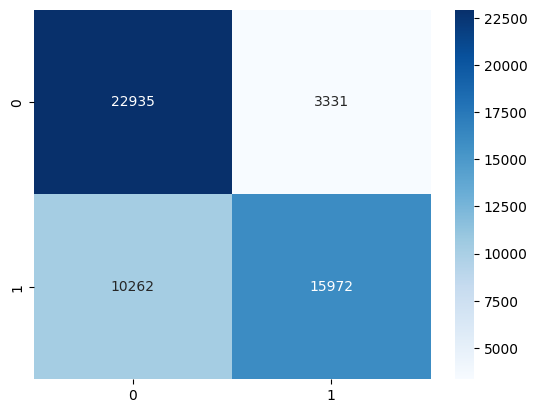

In [34]:
# Матрица ошибок на трейне
conf_matrix = confusion_matrix(y_score_train.squeeze(), np.round(res_train))
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'd')

<Axes: >

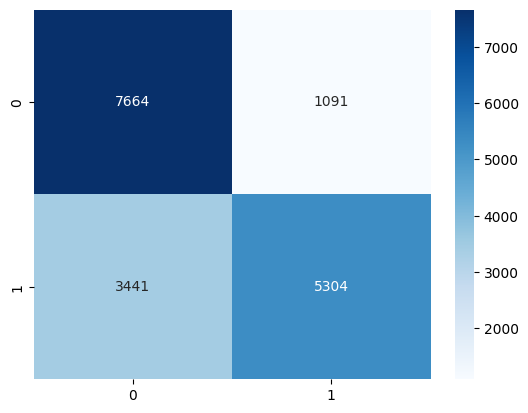

In [35]:
# Матрица ошибок на тесте
conf_matrix = confusion_matrix(y_score_test.squeeze(), np.round(res_test))
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'd')

In [32]:
# Выделение функции потерь
train_losses = []
val_losses = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    outputs = model_scores(X_score_train_tensor)
    train_loss = criterion(outputs.squeeze(), y_score_train_tensor.float())
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model_scores(X_score_valid_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_score_valid_tensor.float())

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}: Train Loss = {train_loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

Epoch 1: Train Loss = 0.6155, Val Loss = 0.6157
Epoch 2: Train Loss = 0.6155, Val Loss = 0.6157
Epoch 3: Train Loss = 0.6155, Val Loss = 0.6157
Epoch 4: Train Loss = 0.6155, Val Loss = 0.6157
Epoch 5: Train Loss = 0.6155, Val Loss = 0.6157
Epoch 6: Train Loss = 0.6155, Val Loss = 0.6157
Epoch 7: Train Loss = 0.6155, Val Loss = 0.6157
Epoch 8: Train Loss = 0.6155, Val Loss = 0.6157
Epoch 9: Train Loss = 0.6155, Val Loss = 0.6157
Epoch 10: Train Loss = 0.6155, Val Loss = 0.6157
Epoch 11: Train Loss = 0.6154, Val Loss = 0.6157
Epoch 12: Train Loss = 0.6154, Val Loss = 0.6157
Epoch 13: Train Loss = 0.6154, Val Loss = 0.6157
Epoch 14: Train Loss = 0.6154, Val Loss = 0.6157
Epoch 15: Train Loss = 0.6154, Val Loss = 0.6157
Epoch 16: Train Loss = 0.6154, Val Loss = 0.6157
Epoch 17: Train Loss = 0.6154, Val Loss = 0.6157
Epoch 18: Train Loss = 0.6154, Val Loss = 0.6157
Epoch 19: Train Loss = 0.6154, Val Loss = 0.6157
Epoch 20: Train Loss = 0.6154, Val Loss = 0.6157
Epoch 21: Train Loss = 0.6154

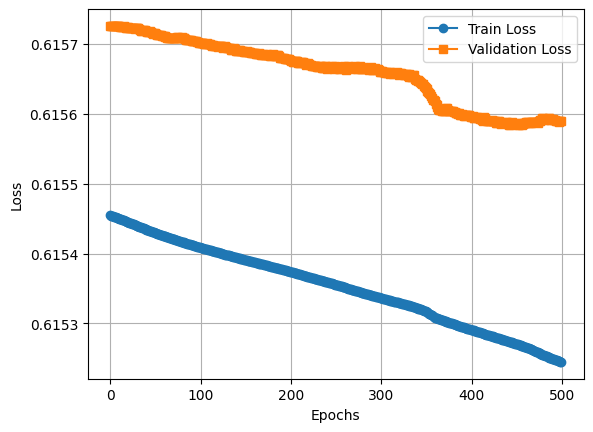

In [33]:
# Графики функций потерь на трейне и валидации для оценки переобучения
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Метрики, полученные с Random Forest:

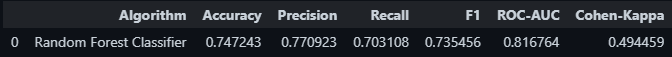

# Вывод

Ожидаемо, оба варианта моделей на Pytorch получились гораздо стабильнее с тз переобучения, а также заметно лучше по качеству. 

При этом, имеет смысл использовать такую модель как в качестве альтернативы XGB с optuna и кросс-валидацией, так и для её ансамблирования вместо Random Forest. В приоритете на последнем этапе для разнообразия добавить на прод именно второй вариант в виду того, что проект учебный (а тем более мультимодальный) с целью демонстрации гибкости. Также под данную идею прекрасно вписывается добавить просто альтернативный вариант с FCNN...

Сохраним параметры этих двух финальных моделей для дальнейшего использования:

In [36]:
torch.save(model.state_dict(), "../models/fcnn_model_weights.pth")
torch.save(model.state_dict(), "../models/fcnn_model_encemble_weights.pth")